## Please refer to the Kaggle_Comp_Linux.ipynb file for documentation.

The only step that is different for windows is where we get image files and set it in test_files variable. Windows does not sort the files like Linux does, so we include the ".sorted()" function to sort them.

In [1]:
from pathlib import Path
base_folder = Path("d:\\OneDrive - The University of Texas at Dallas\\6382\\Datasets\\")

In [2]:
data_folder = base_folder/'data'
model_folder = base_folder/'models/Inclass_DL_Kaggle_Comp/'
archive_folder = base_folder/'archive/'
# kaggle_api = base_folder/'.kaggle'

In [3]:
from fastai.vision.all import *
# from kaggle import api
from fastcore.parallel import *

The below step is different for Windows

In [4]:
train_path = data_folder/'train'
test_path = data_folder/'test'
train_files = get_image_files(train_path)
test_files = get_image_files(test_path).sorted()

In [6]:
test_files

(#3929) [Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/0.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/10.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/100.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1000.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1001.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1002.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1003.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1004.JPEG'),Path('d:/OneDrive - The University of Texas at Dallas/6382/Datasets/data/test/test/1005.JPEG')...]

In [8]:
dblock = DataBlock(blocks = [ImageBlock, CategoryBlock],
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(seed = 42),
                   item_tfms= Resize(size= 180, method = 'squish'),
                   batch_tfms= aug_transforms(size = 128, min_scale = 1)
                   )

In [9]:
dls = dblock.dataloaders(data_folder/'train/train', bs = 64)

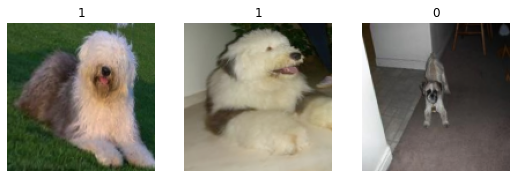

In [10]:
dls.train.show_batch(max_n = 3)

In [11]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

In [58]:
gc.collect()
torch.cuda.empty_cache()

In [59]:
learn = vision_learner(dls, 'convnext_small', metrics= error_rate, path = model_folder).to_fp16()

SuggestedLRs(minimum=0.010000000149011612)

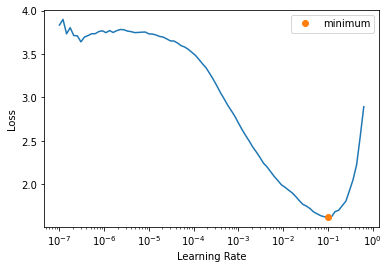

In [61]:
learn.lr_find(suggest_funcs= (minimum))

In [62]:
torch.cuda.empty_cache()
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.380784,0.269297,0.070914,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.243595,0.236702,0.058172,00:52
1,0.192406,0.198117,0.054294,00:52
2,0.099715,0.178306,0.053186,00:54


In [63]:
test_dl = dls.test_dl(test_files)

In [64]:
preds, _ = learn.tta(dl = test_dl)

In [46]:
idxs = preds.argmax(dim = 1)
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name = 'idxs')

In [47]:
results

0       7
1       2
2       0
3       5
4       3
       ..
3924    7
3925    7
3926    8
3927    3
3928    6
Name: idxs, Length: 3929, dtype: object

In [49]:
ss = pd.read_csv(data_folder/'sample_submission.csv')
ss['target'] = 0
ss.head(10)

,file_names,target
0,0.JPEG,0
1,1.JPEG,0
2,2.JPEG,0
3,3.JPEG,0
4,4.JPEG,0
5,5.JPEG,0
6,6.JPEG,0
7,7.JPEG,0
8,8.JPEG,0
9,9.JPEG,0


In [50]:
ss.sort_values(by = ['file_names'], inplace = True, ignore_index = True)
ss['target'] = results
ss.head(10)

,file_names,target
0,0.JPEG,7
1,1.JPEG,2
2,10.JPEG,0
3,100.JPEG,5
4,1000.JPEG,3
5,1001.JPEG,5
6,1002.JPEG,3
7,1003.JPEG,3
8,1004.JPEG,8
9,1005.JPEG,1


In [51]:
ss.to_csv(archive_folder/'convnext_small.csv', index = False)